In [65]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm


# The Data

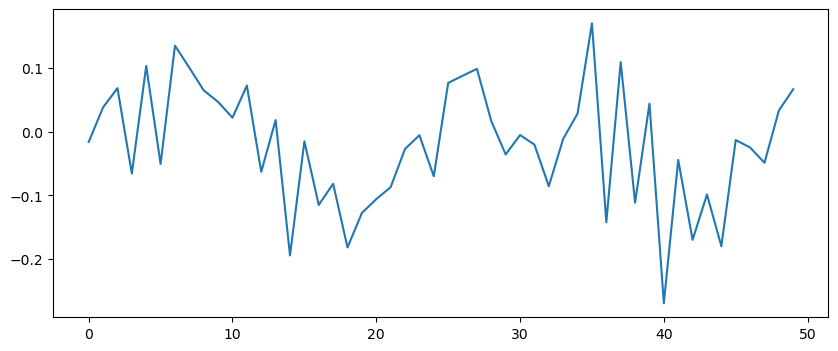

In [66]:
true_phi_1 = -0.2
true_phi_2 = 0.5
true_sigma = 0.1

xvals = [np.random.normal(0, true_sigma), np.random.normal(0, true_sigma)]
for _ in range(50):
    xvals.append(true_phi_1*xvals[-1] + true_phi_2*xvals[-2] + np.random.normal(0, true_sigma))
xvals = np.array(xvals[2:])
plt.figure(figsize=(10,4))
plt.plot(xvals)

# Usual Method : Fit AR Model

In [67]:
model = sm.tsa.arima.ARIMA(xvals, order=(2,0,0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   50
Model:                 ARIMA(2, 0, 0)   Log Likelihood                  57.509
Date:                Wed, 24 May 2023   AIC                           -107.018
Time:                        18:02:41   BIC                            -99.370
Sample:                             0   HQIC                          -104.105
                                 - 50                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0156      0.033     -0.471      0.638      -0.081       0.049
ar.L1          0.0603      0.131      0.459      0.646      -0.197       0.318
ar.L2          0.5620      0.165      3.396      0.001       0.238       0.886
sigma2         0.0058      0.001      4.950      0.000       0.003       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                 0.50
Prob(Q):                              0.57   Prob(JB):                         0.78
Heteroskedasticity (H):               1.87   Skew:                            -0.22
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

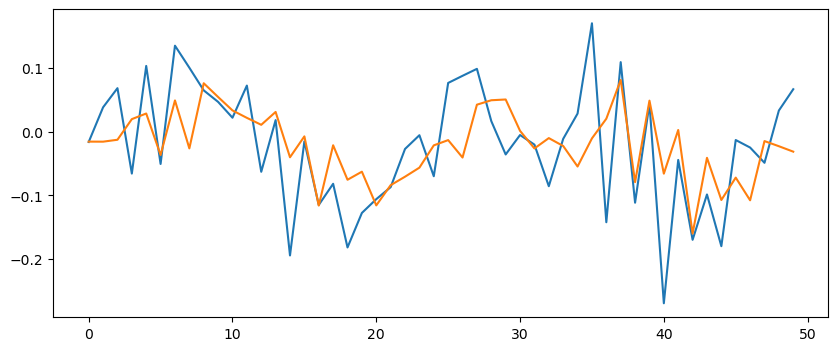

In [68]:
plt.figure(figsize=(10,4))
plt.plot(xvals)
plt.plot(model.fittedvalues)

In [69]:
forcastNew = model.get_prediction(0, 55)
forcastNew.conf_int([0.05])[50:55]

array([[-0.13227617,  0.16565553],
       [-0.11676743,  0.18170466],
       [-0.16594424,  0.17681431],
       [-0.15900423,  0.18435159],
       [-0.18033449,  0.17616898]])

In [70]:
forcastNew

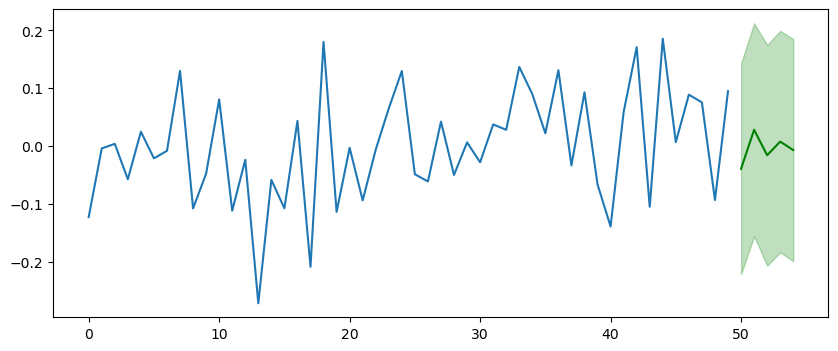

In [48]:
plt.figure(figsize=(10,4))
plt.plot(xvals)
forecast = model.forecast(5)

plt.plot(range(len(xvals), len(xvals) + 5), forecast, color='g')
plt.fill_between(range(len(xvals), len(xvals) + 5), forcastNew.conf_int([0.05])[50:55][:,0], forcastNew.conf_int([0.05])[50:55][:,1], color='g', alpha=0.25)

# Bayesian Analysis with PyMC3
***

# Priors:
## $\phi_1 \sim N(0,20)$
## $\phi_2 \sim N(0,20)$
## $\sigma \sim Exp(1)$
***

# Likelihood:
## $x_t|\phi_1, \phi_2, \sigma, x_{t-1}, x_{t-2} \sim N(\phi_1 x_{t-1} + \phi_2 x_{t-2}, \sigma)$
***

# Posterior
## $\phi_1, \phi_2, \sigma|x \sim ?$
***

C:\Users\fridm\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, phi]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
C:\Users\fridm\AppData\Local\Temp\ipykernel_23360\911109068.py:13: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fridm\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


<Figure size 700x700 with 0 Axes>

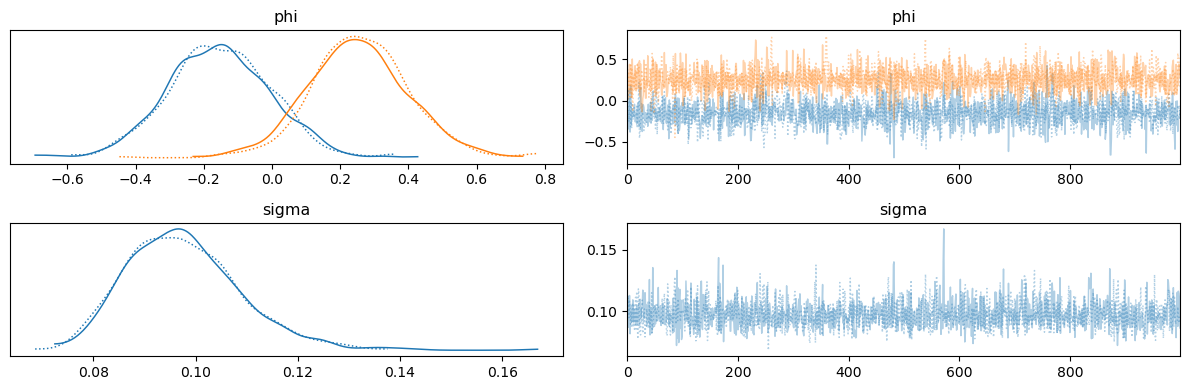

In [49]:
with pm.Model() as bayes_model:
    #priors
    phi = pm.Normal("phi", mu=0, sigma=20, shape=2)
    sigma = pm.Exponential("sigma", lam=1)

    #Likelihood
    likelihood = pm.AR("x", phi, sigma, observed=xvals)

    #posterior
    trace = pm.sample(1000, cores=2)
    
plt.figure(figsize=(7, 7))
pm.traceplot(trace)
plt.tight_layout()

# Parameter Distributions

C:\Users\fridm\AppData\Local\Temp\ipykernel_23360\1404322737.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(phi1_vals)


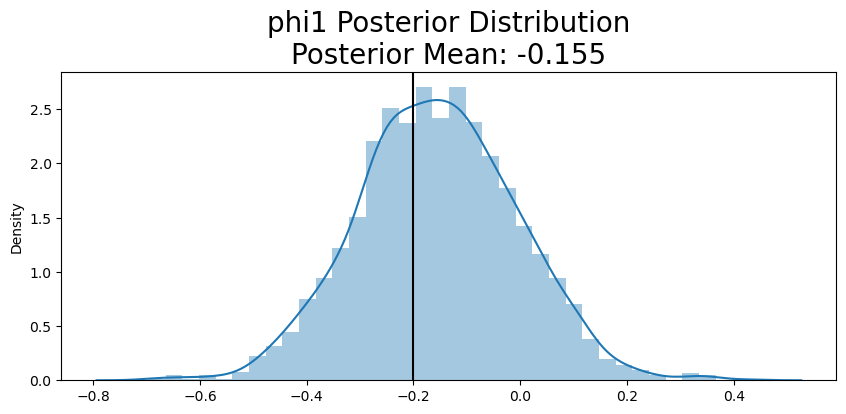

C:\Users\fridm\AppData\Local\Temp\ipykernel_23360\1404322737.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(phi2_vals)


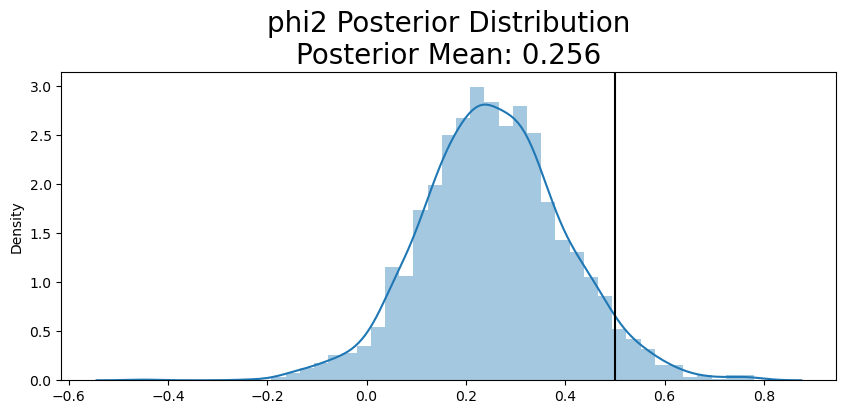

C:\Users\fridm\AppData\Local\Temp\ipykernel_23360\1404322737.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sigma_vals)


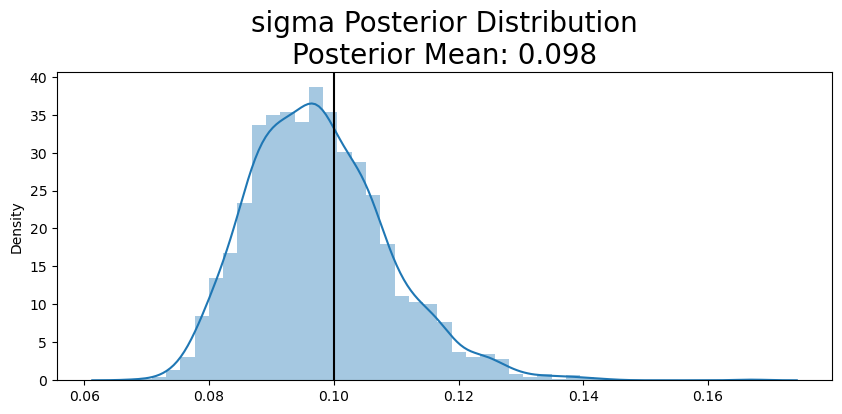

In [50]:
phi1_vals = trace.get_values('phi')[:,0]
phi2_vals = trace.get_values('phi')[:,1]
sigma_vals = trace.get_values('sigma')

plt.figure(figsize=(10,4))
sns.distplot(phi1_vals)
plt.axvline(true_phi_1, color='k')
plt.title('phi1 Posterior Distribution\nPosterior Mean: %s'%round(phi1_vals.mean(), 3), fontsize=20)
plt.show()

plt.figure(figsize=(10,4))
sns.distplot(phi2_vals)
plt.axvline(true_phi_2, color='k')
plt.title('phi2 Posterior Distribution\nPosterior Mean: %s'%round(phi2_vals.mean(), 3), fontsize=20)
plt.show()

plt.figure(figsize=(10,4))
sns.distplot(sigma_vals)
plt.axvline(true_sigma, color='k')
plt.title('sigma Posterior Distribution\nPosterior Mean: %s'%round(sigma_vals.mean(), 3), fontsize=20)
plt.show()

# Forecast Next Values

In [51]:
num_samples = 10000
forecasted_vals = []
num_periods = 5

for _ in range(num_samples):
    curr_vals = list(xvals.copy())
    
    phi1_val = np.random.choice(phi1_vals)
    phi2_val = np.random.choice(phi2_vals)
    sigma_val = np.random.choice(sigma_vals)
    
    for _ in range(num_periods):
        curr_vals.append(curr_vals[-1]*phi1_val + curr_vals[-2]*phi2_val + np.random.normal(0, sigma_val))
    forecasted_vals.append(curr_vals[-num_periods:]) 
forecasted_vals = np.array(forecasted_vals)

In [61]:
forecasted_vals[:,0].mean()

-0.03863461351198638

C:\Users\fridm\AppData\Local\Temp\ipykernel_23360\328998031.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(vals)
C:\Users\fridm\AppData\Local\Temp\ipykernel_23360\328998031.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(vals)
C:\Users\fridm\AppData\Local\Temp\ipykernel_23360\328998031.

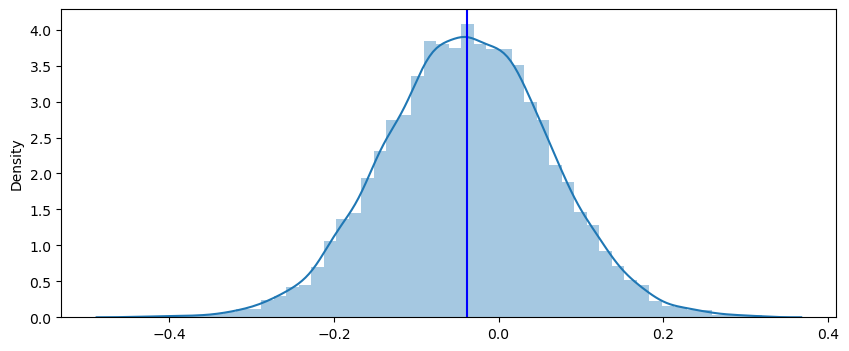

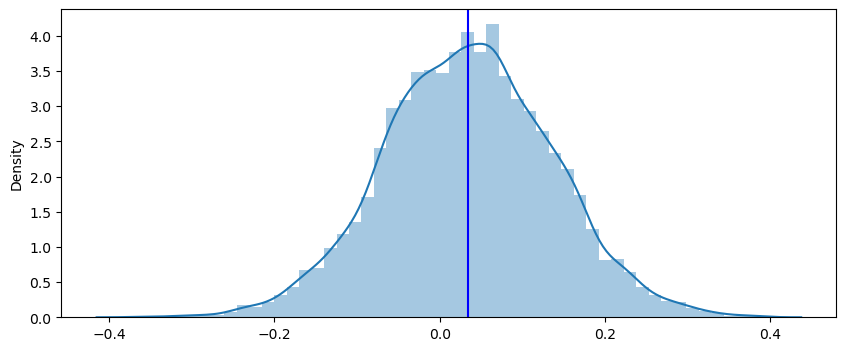

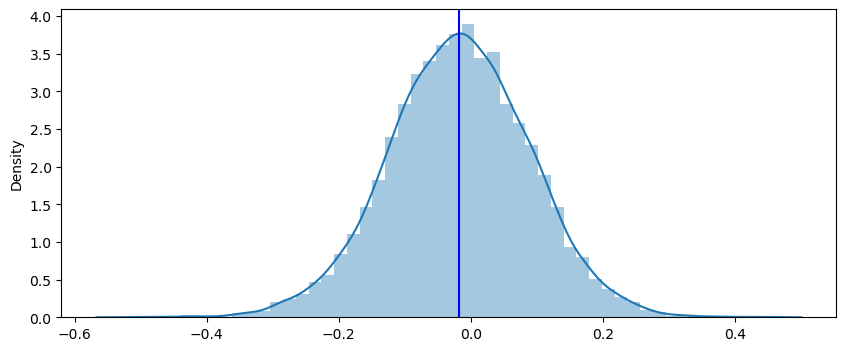

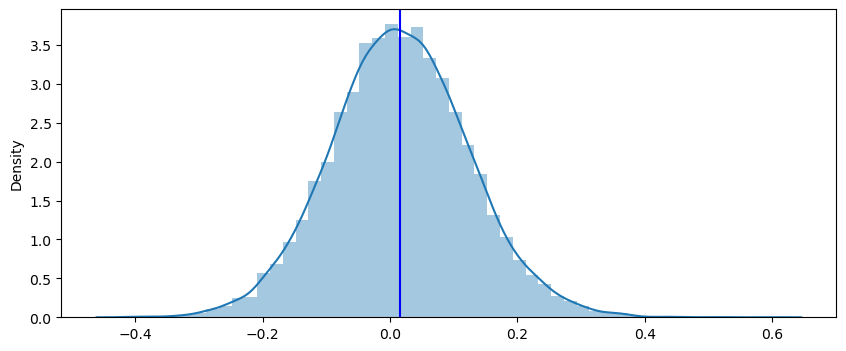

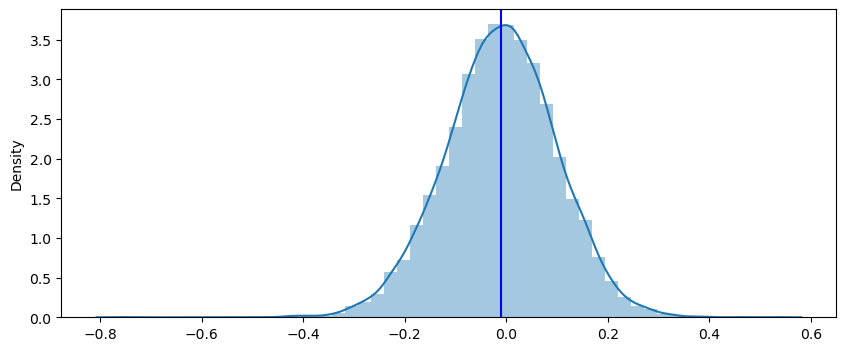

In [64]:
for i in range(num_periods):
    plt.figure(figsize=(10,4))
    vals = forecasted_vals[:,i]
    mu, dev = round(vals.mean(), 3), round(vals.std(), 3)
    sns.distplot(vals)
    #p1 = plt.axvline(forecast[0][i], color='k')
    p2 = plt.axvline(vals.mean(), color='b')
    #plt.legend((p1,p2), ('MLE', 'Posterior Mean'), fontsize=20)
    #plt.title('Forecasted t+%s\nPosterior Mean: %s\nMLE: %s\nSD Bayes: %s\nSD MLE: %s'%((i+1), mu, round(forecast[0][i],3), dev, round(forecast[1][i],3)), fontsize=20)